In [1]:
# !pip install -e /home/jovyan/PROJECTS/scale-aware-air-sea

In [2]:
#TODO: I want attrs to propagate through...need to start in the first step though...

In [3]:
import gcsfs
import xarray as xr
import numpy as np
from scale_aware_air_sea.utils import smooth_inputs_dataset, to_zarr_split, open_zarr, weighted_coarsen
from scale_aware_air_sea.parameters import get_params

In [4]:
fs = gcsfs.GCSFileSystem()

# load global parameters
params = get_params('v0.6.2', test=True)  

mapper_smooth_fluxes = fs.get_mapper(params['paths']['CM26']['smooth_fluxes'])
mapper_coarse_fluxes = fs.get_mapper(params['paths']['CM26']['coarse_fluxes'])

mapper_smooth_flux_decomposition = fs.get_mapper(params['paths']['CM26']['smooth_decomposition'])
mapper_coarse_flux_decomposition = fs.get_mapper(params['paths']['CM26']['coarse_decomposition'])

In [17]:
# new scale separation
def decomposition_smooth(ds):
    """Decomposing filtered flux outputs into different terms to evaluate"""
    def filt(ds):
        return smooth_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], 50)

    # Q_H (AB) - high resolution input
    Q_H = ds.sel(smoothing='smooth_none')
    Q_H_bar = filt(Q_H)
    # Q_L low resolution input
    Q_L = ds.sel(smoothing='smooth_all')
    Q_L_bar = filt(Q_L)
    Q_L_prime = Q_L - Q_L_bar # TODO: I could potentially compute this on the fly...
    
    # Inferred Small scale
    #Q_star = Q_H_bar - Q_L
    Q_star_star = Q_H_bar - Q_L_bar
    
    # mixed low resolution input
    Q_L_ocean = ds.sel(smoothing='smooth_vel_tracer_ocean')
    Q_L_ocean_bar = filt(Q_L_ocean)
    
    Q_L_atmos = ds.sel(smoothing='smooth_vel_tracer_atmos')
    Q_L_atmos_bar = filt(Q_L_atmos)
    
    #Q_star_ocean = Q_H_bar - Q_L_ocean
    #Q_star_ocean_bar = filt(Q_star_ocean)
    Q_star_star_ocean = Q_H_bar - Q_L_ocean_bar
    
    #Q_star_atmos = Q_H_bar - Q_L_atmos
    #Q_star_atmos_bar = filt(Q_star_atmos)
    Q_star_star_atmos = Q_H_bar - Q_L_atmos_bar
    
    #Q_star_res_wrong = Q_star - Q_star_star_ocean - Q_star_star_atmos
    #Q_star_res = Q_star - Q_star_ocean - Q_star_atmos
    #Q_star_star_res = Q_star_star - Q_star_star_ocean - Q_star_star_atmos 
    
    # for testing
    #Q_H_bar_bar = filt(Q_H_bar)
    #Q_star_star_star = Q_H_bar_bar - Q_L_bar
    #Q_star_res = Q_star - Q_star_ocean - Q_star_atmos
    
    # concat into a single dataset
    datasets = [ds.assign_coords(term=k) for ds,k in [
        (Q_star_star, 'Q_star_star'),
        (Q_star_star_ocean, 'Q_star_star_ocean'), 
        (Q_star_star_atmos, 'Q_star_star_atmos')]
               ]
    ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
    ds_out.attrs = ds.attrs
    return ds_out



def decomposition_smooth_old(ds):
    """Decomposing filtered flux outputs into different terms to evaluate"""
    def filt(ds):
        return smooth_inputs_dataset(ds, ['yt_ocean', 'xt_ocean'], 50)
    decomp = {}
    # Q_H (AB) - high resolution input
    decomp['Q_H'] = ds.sel(smoothing='smooth_none')
    decomp['Q_H_bar'] = filt(decomp['Q_H'])
    # Q_L low resolution input
    decomp['Q_L'] = ds.sel(smoothing='smooth_all')
    decomp['Q_L_bar'] = filt(decomp['Q_L'])
    decomp['Q_L_prime'] = decomp['Q_L'] - decomp['Q_L_bar'] # TODO: I could potentially compute this on the fly...

    
    
    # Inferred Small scale
    decomp['Q_star'] = decomp['Q_H_bar'] - decomp['Q_L']
    decomp['Q_star_star'] = decomp['Q_H_bar'] - decomp['Q_L_bar']
    
    # mixed low resolution input
    decomp['Q_L_ocean'] = ds.sel(smoothing='smooth_vel_tracer_ocean')
    decomp['Q_L_ocean_bar'] = filt(decomp['Q_L_ocean'])
    
    decomp['Q_L_atmos'] = ds.sel(smoothing='smooth_vel_tracer_atmos')
    decomp['Q_L_atmos_bar'] = filt(decomp['Q_L_atmos'])
    
    decomp['Q_star_ocean'] = decomp['Q_H_bar'] - decomp['Q_L_ocean']
    decomp['Q_star_ocean_bar'] = filt(decomp['Q_star_ocean'])
    decomp['Q_star_star_ocean'] = decomp['Q_H_bar'] - decomp['Q_L_ocean_bar']
    
    decomp['Q_star_atmos'] = decomp['Q_H_bar'] - decomp['Q_L_atmos']
    decomp['Q_star_atmos_bar'] = filt(decomp['Q_star_atmos'])
    decomp['Q_star_star_atmos'] = decomp['Q_H_bar'] - decomp['Q_L_atmos_bar']
    
    decomp['Q_star_res_wrong'] = decomp['Q_star'] - decomp['Q_star_star_ocean'] - decomp['Q_star_star_atmos']
    decomp['Q_star_res'] = decomp['Q_star'] - decomp['Q_star_ocean'] - decomp['Q_star_atmos']
    decomp['Q_star_star_res'] = decomp['Q_star_star'] - decomp['Q_star_star_ocean'] - decomp['Q_star_star_atmos'] 
    
    # for testing
    decomp['Q_H_bar_bar'] = filt(decomp['Q_H_bar'])
    decomp['Q_star_star_star'] = decomp['Q_H_bar_bar'] - decomp['Q_L_bar']
    decomp['Q_star_res'] = decomp['Q_star'] - decomp['Q_star_ocean'] - decomp['Q_star_atmos']
    
    # concat into a single dataset
    datasets = [ds.drop([dvar for dvar in ['smoothing'] if dvar in ds]).assign_coords(term=k) for k,ds in decomp.items()]
    ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
    ds_out.attrs = ds.attrs
    return ds_out

def decomposition_coarsened(ds_filter, ds_coarse):
    def smooth(ds):
        return weighted_coarsen(
            ds, 
            {'xt_ocean':params['n_coarsen'], 'yt_ocean':params['n_coarsen']}, 
            'area_t'
        )
    
    decomp = {}
    # Q_H (AB) - high resolution input
    Q_H = ds_filter.sel(smoothing='smooth_none') # dont include in dict, because it has different size
    decomp['Q_H_bar'] = smooth(Q_H)
    # Q_L low resolution input
    decomp['Q_L'] = ds_coarse.sel(smoothing='smooth_all')

    
    # Inferred Small scale
    decomp['Q_star'] = decomp['Q_H_bar'] - decomp['Q_L']
    
    # concat into a single dataset
    datasets = [ds.drop([dvar for dvar in ['smoothing'] if dvar in ds]).assign_coords(term=k) for k,ds in decomp.items()]
    ds_out = xr.concat(datasets, dim='term', combine_attrs="override")
    ds_out.attrs = ds_coarse.attrs
    return ds_out

In [6]:
# ds_smooth_fluxes = open_zarr(mapper_smooth_fluxes)
ds_smooth_fluxes = open_zarr(mapper_smooth_fluxes)#, chunks={'time':1}
ds_smooth_fluxes

<xarray.Dataset>
Dimensions:    (algo: 2, yt_ocean: 2700, xt_ocean: 3600, smoothing: 7, time: 300)
Coordinates: (12/13)
  * algo       (algo) <U5 'ncar' 'ecmwf'
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t   (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...         ...
    kmt        (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * smoothing  (smoothing) <U23 'smooth_none' 'smooth_tracer' ... 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    wet        (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean   (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean   (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
Data variables:
    evap       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    qh         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql         (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    taux       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    tauy       (algo, smoothing, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

In [7]:
# ds_smooth_fluxes = open_zarr(mapper_smooth_fluxes)
ds_coarse_fluxes = open_zarr(mapper_coarse_fluxes)#, chunks={'time':1}
ds_coarse_fluxes

<xarray.Dataset>
Dimensions:    (algo: 2, yt_ocean: 54, xt_ocean: 72, smoothing: 2, time: 300)
Coordinates:
  * algo       (algo) <U5 'ncar' 'ecmwf'
    area_t     (yt_ocean, xt_ocean) float64 dask.array<chunksize=(54, 72), meta=np.ndarray>
  * smoothing  (smoothing) <U11 'smooth_none' 'smooth_all'
  * time       (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    evap       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    qh         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    ql         (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    taux       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    tauy       (smoothing, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>

In [18]:
smooth_decomp = decomposition_smooth(ds_smooth_fluxes)
smooth_decomp

<xarray.Dataset>
Dimensions:   (algo: 2, yt_ocean: 2700, xt_ocean: 3600, time: 300, term: 3)
Coordinates: (12/13)
  * algo      (algo) <U5 'ncar' 'ecmwf'
    area_t    (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dxt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    dyt       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolat_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    geolon_t  (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
    ...        ...
    kmt       (yt_ocean, xt_ocean) float32 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * time      (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    wet       (yt_ocean, xt_ocean) float64 dask.array<chunksize=(2700, 3600), meta=np.ndarray>
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * term      (term) <U17 'Q_star_star' 'Q_star_star_ocean' 'Q_star_star_atmos'
Data variables:
    evap      (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    qh        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    ql        (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    taux      (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>
    tauy      (term, algo, time, yt_ocean, xt_ocean) float32 dask.array<chunksize=(1, 1, 3, 2700, 3600), meta=np.ndarray>

In [19]:
coarse_decomp = decomposition_coarsened(ds_smooth_fluxes, ds_coarse_fluxes)
coarse_decomp

<xarray.Dataset>
Dimensions:  (algo: 2, time: 300, term: 3, yt_ocean: 54, xt_ocean: 72)
Coordinates:
  * algo     (algo) <U5 'ncar' 'ecmwf'
  * time     (time) object 0181-01-01 12:00:00 ... 0181-10-27 12:00:00
    area_t   (yt_ocean, xt_ocean) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
  * term     (term) <U7 'Q_H_bar' 'Q_L' 'Q_star'
Dimensions without coordinates: yt_ocean, xt_ocean
Data variables:
    evap     (term, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    qh       (term, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    ql       (term, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    taux     (term, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>
    tauy     (term, algo, time, yt_ocean, xt_ocean) float64 dask.array<chunksize=(1, 1, 3, 54, 72), meta=np.ndarray>

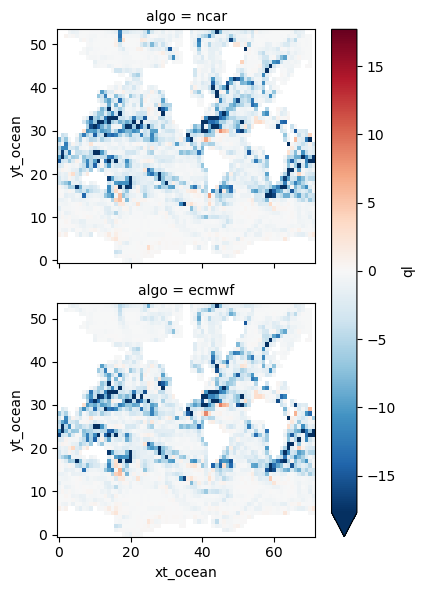

In [20]:
coarse_decomp['ql'].isel(time=0).sel(term='Q_star').plot(row='algo', robust=True)

In [ ]:
# import dask, distributed
# dask.config.set(
#     {
#         "distributed.worker.memory.target":False,
#         "distributed.worker.memory.spill":False
#         "logging.distributed"="debug",
#         "distributed.scheduler.worker-ttl": "1200s"
#     }
# )
# dask.config.get('distributed.worker.memory')

# # try a local cluster for testing
# from distributed import Client, LocalCluster
# cluster = LocalCluster(n_workers=4, threads_per_worker=4)
# client = Client(cluster)
# client

In [9]:
from dask_gateway import Gateway
gateway = Gateway()

# close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
        cluster = gateway.connect(c.name)
        cluster.shutdown()
print('setting up new cluster')

options = gateway.cluster_options()
# options.environment = dict(
#     DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0",
# )
# options.worker_memory = 12
# options.worker_cores = 2
options.worker_memory = 24
options.worker_cores = 5
options

[ClusterReport<name=prod.62c60e6dfaaf4af5b89d013e1d19051d, status=RUNNING>]
setting up new cluster


/srv/conda/envs/notebook/lib/python3.10/site-packages/jupyter_client/session.py:719: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Options<worker_cores=5,
        worker_memory=24.0,
        image='pangeo/pangeo-notebook:ebeb9dd',
        environment={'SCRATCH_BUCKET': 'gs://leap-scratch/jbusecke',
         'PANGEO_SCRATCH': 'gs://leap-scratch/jbusecke'}>


In [10]:
# Create a cluster with those options
cluster = gateway.new_cluster(options)
client = cluster.get_client()

# cluster.adapt(10, 200)
cluster.scale(100)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.762a18ce672441b6a2b719d322daca18/status,


In [11]:
# from dask_gateway import Gateway
# gateway = Gateway()

# # close existing clusters
# open_clusters = gateway.list_clusters()
# print(list(open_clusters))
# if len(open_clusters)>0:
#     for c in open_clusters:
#         cluster = gateway.connect(c.name)
#         cluster.shutdown()
# print('setting up new cluster')

# options = gateway.cluster_options()
# options.worker_memory = 52
# options.worker_cores = 6

# options.environment = dict(
#     DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0",
#     DASK_LOGGING__DISTRIBUTED="debug", # TODO: Testing this
#     DASK_DISTRIBUTED__SCHEDULER__ALLOWED_FAILURES="5",
#     DASK_DISTRIBUTED__SCHEDULER__IDLE_TIMEOUT="1200s",
#     DASK_DISTRIBUTED__COMM__TIMEOUTS__TCP="1200s",
#     DASK_DISTRIBUTED__COMM__TIMEOUTS__CONNECT="1200s",
#     DASK_DISTRIBUTED__SCHEDULER__WORK_STEALING="False", # Test
#     DASK_DISTRIBUTED__DEPLOY__LOST_WORKER_TIMEOUT="1200s",
#     DASK_DISTRIBUTED__SCHEDULER__WORKER_TTL="1200s",
#     DASK_DISTRIBUTED__WORKER__MEMORY__TARGET="False", # was this blocking because of "false"? This should also raise an error
#     DASK_DISTRIBUTED__WORKER__MEMORY__SPILL="False",
#     DASK_DISTRIBUTED__WORKER__MEMORY__PAUSE="0.85",
# )

# # Create a cluster with those options
# cluster = gateway.new_cluster(options)
# client = cluster.get_client()

# # cluster.adapt(10, 200)
# cluster.scale(40)

# def check_config():
#     import dask
#     return dask.config.get('distributed.worker.memory')

# print(client.run(check_config))

# client

In [12]:
# from dask.distributed import LocalCluster, Client
# cluster = LocalCluster()
# client = Client(cluster)
# client

### Save out smooth decomp

In [15]:
#fs.rm(mapper_smooth_flux_decomposition.root, recursive=True)

In [21]:
ds_save = smooth_decomp
for va in ds_save.variables:
    if 'chunks' in ds_save[va].encoding.keys():
        print(va)
        del ds_save[va].encoding['chunks']

algo
area_t
dxt
dyt
geolat_t
geolon_t
ht
kmt
time
wet
xt_ocean
yt_ocean


In [22]:
print(f"{ds_save.nbytes/1e12}TB")
to_zarr_split(
    ds_save,
    mapper_smooth_flux_decomposition,
    split_interval=300
)

0.350386613044TB
Writing to leap-persistent/jbusecke/scale-aware-air-sea/results/CM26_fluxes_smoothed_decomposed_v0.6.2test.zarr ...


2023-02-22 18:10:53,616 - distributed.client - WARNING - Couldn't gather 40 keys, rescheduling {"('store-map-38162bf5a4feca4b09f9b1b6be6bf268', 2, 1, 72, 0, 0)": (), "('store-map-4c06e726279c158b1780da859bf588cd', 2, 1, 20, 0, 0)": (), "('store-map-0825665effa05c014c3fa6adabe46d68', 2, 0, 18, 0, 0)": (), "('store-map-a975ac6bf9a36738fa45da8e45afcdc9', 1, 0, 67, 0, 0)": (), "('store-map-13a5a2f8b2610b525bb326c7bcb5c838', 0, 0, 61, 0, 0)": (), "('store-map-38162bf5a4feca4b09f9b1b6be6bf268', 2, 0, 1, 0, 0)": (), "('store-map-38162bf5a4feca4b09f9b1b6be6bf268', 2, 0, 82, 0, 0)": (), "('store-map-38162bf5a4feca4b09f9b1b6be6bf268', 1, 1, 78, 0, 0)": (), "('store-map-38162bf5a4feca4b09f9b1b6be6bf268', 2, 1, 24, 0, 0)": (), "('store-map-0825665effa05c014c3fa6adabe46d68', 2, 0, 85, 0, 0)": (), "('store-map-13a5a2f8b2610b525bb326c7bcb5c838', 2, 0, 15, 0, 0)": (), "('store-map-4c06e726279c158b1780da859bf588cd', 2, 0, 5, 0, 0)": (), "('store-map-a975ac6bf9a36738fa45da8e45afcdc9', 2, 0, 67, 0, 0)": 

0it [00:00, ?it/s]

### save out coarsened decomp

In [25]:
ds_save = coarse_decomp

print(f"{ds_save.nbytes/1e9}GB")
ds_save.to_zarr(mapper_coarse_flux_decomposition, mode='w')

0.279969628GB


In [27]:
print('hell0')

hell0


In [26]:
client.close()

In [28]:
cluster.shutdown()